In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import datetime as dt
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

In [35]:
#read data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

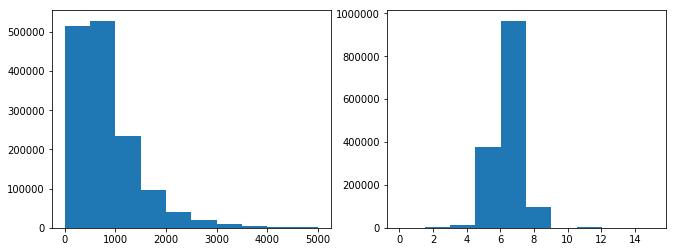

In [49]:
# trip_duration are skew
f,ax = plt.subplots(ncols = 2,figsize=(11,4))
ax[0].hist(train['trip_duration'].values,bins = 10,range = (0,5000))
ax[1].hist(np.log(train['trip_duration'].values))
plt.show()

train['np_trip_duration'] = np.log(train['trip_duration'].values )

Feature engineering

In [5]:
#transform geographic information into coordinate with PCA
from sklearn.decomposition import PCA
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [13]:
# calculate distance&direction between pickup coordinate and  dropoff coordinate
# distance_manhattan  
# distance_haversine
# direction
AVG_EARTH_RADIUS = 6371 

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
     
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def direction_lat_lng(lat1, lng1, lat2, lng2):   
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))  #Convert angles from degrees to radians.
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


def distance(x1,y1,x2,y2):
    return np.sqrt((y2 - y1)**2 + (x2 - x1)**2)*AVG_EARTH_RADIUS
    
train['distance'] = distance(train.pickup_longitude, train.pickup_latitude, train.dropoff_longitude, train.dropoff_latitude)
test['distance'] = distance(test.pickup_longitude, test.pickup_latitude, test.dropoff_longitude, test.dropoff_latitude)

train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'direction'] = direction_lat_lng(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_manhattan'] = np.abs(train['dropoff_latitude'] - train['pickup_latitude']) + np.abs(train['dropoff_longitude'] - train['pickup_longitude'])

test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'direction'] = direction_lat_lng(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_manhattan'] = np.abs(test['dropoff_latitude'] - test['pickup_latitude']) + np.abs(test['dropoff_longitude'] - test['pickup_longitude'])


# center coordinate between pickup coordinate and dropoff coordinate
train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

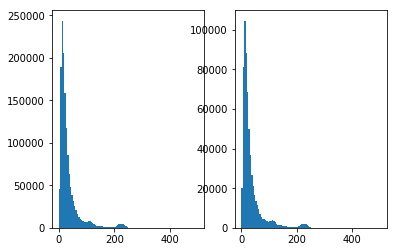

            distance
count  625134.000000
mean       35.400092
std        45.585208
min         0.000000
25%        12.590177
50%        21.215887
75%        38.454316
max     10385.000324
           distance
count  1.439224e+06
mean   3.399332e+01
std    3.982754e+01
min    0.000000e+00
25%    1.251230e+01
50%    2.097058e+01
75%    3.737137e+01
max    3.951234e+02


In [112]:
f,ax = plt.subplots(ncols = 2)
ax[0].hist(train['distance'].values,bins = 100, range = (0,500))
ax[1].hist(test['distance'].values,bins = 100, range = (0,500))
plt.show()
print(test[['distance']].describe())
print(train[['distance']].describe())

(0, 100000)

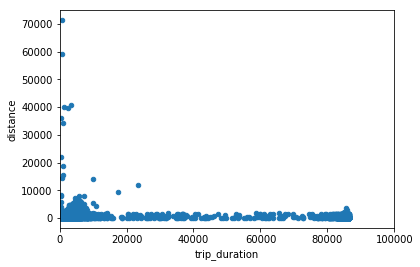

In [14]:
train.plot(kind='scatter', x='trip_duration', y='distance')
plt.xlim((0,100000))

(0, 100000)

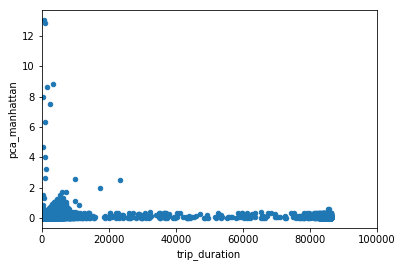

In [10]:
#trip duration and distance
train.plot(kind='scatter', x='trip_duration', y='pca_manhattan')
plt.xlim((0,100000))

In [116]:
# vertical and horizonal difference pickup place and dropoff place 
train['dist_x'] = np.abs(train['pickup_latitude'] - train['dropoff_latitude'])
train['dist_y'] = np.abs(train['pickup_longitude'] - train['pickup_longitude'])
test['dist_x'] = np.abs(test['pickup_latitude'] - test['dropoff_latitude'])
test['dist_y'] = np.abs(test['pickup_longitude'] - test['pickup_longitude'])

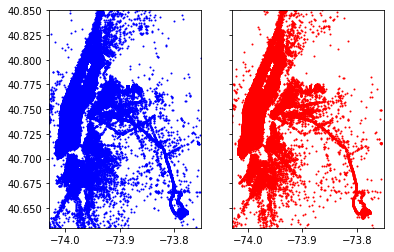

In [104]:
#Nyc city border 
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

#display all the pickup coordinates in train and test data
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'] , train['pickup_latitude'], color = 'blue', s = 1)
ax[1].scatter(test['pickup_longitude'] , test['pickup_latitude'], color = 'red' ,   s = 1)
plt.xlim(city_long_border)
plt.ylim(city_lat_border)

plt.show()

In [106]:
#cluster pickup place 
#with cluster number = 50
from sklearn.cluster import KMeans

df_all = pd.concat([train.drop('trip_duration', axis = 1), test], ignore_index = True )

sample_ind = np.random.permutation(df_all.shape[0])[:500000]
kmeans = MiniBatchKMeans(n_clusters=50, batch_size=10000).fit(df_all[['pickup_longitude','pickup_latitude']].loc[sample_ind].values)

train['pickup_cluster'] = kmeans.predict(train[['pickup_longitude','pickup_latitude']])
test['pickup_cluster'] = kmeans.predict(test[['pickup_longitude','pickup_latitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_longitude','dropoff_latitude']])
test['dropoff_cluster'] = kmeans.predict(test[['dropoff_longitude','dropoff_latitude']])

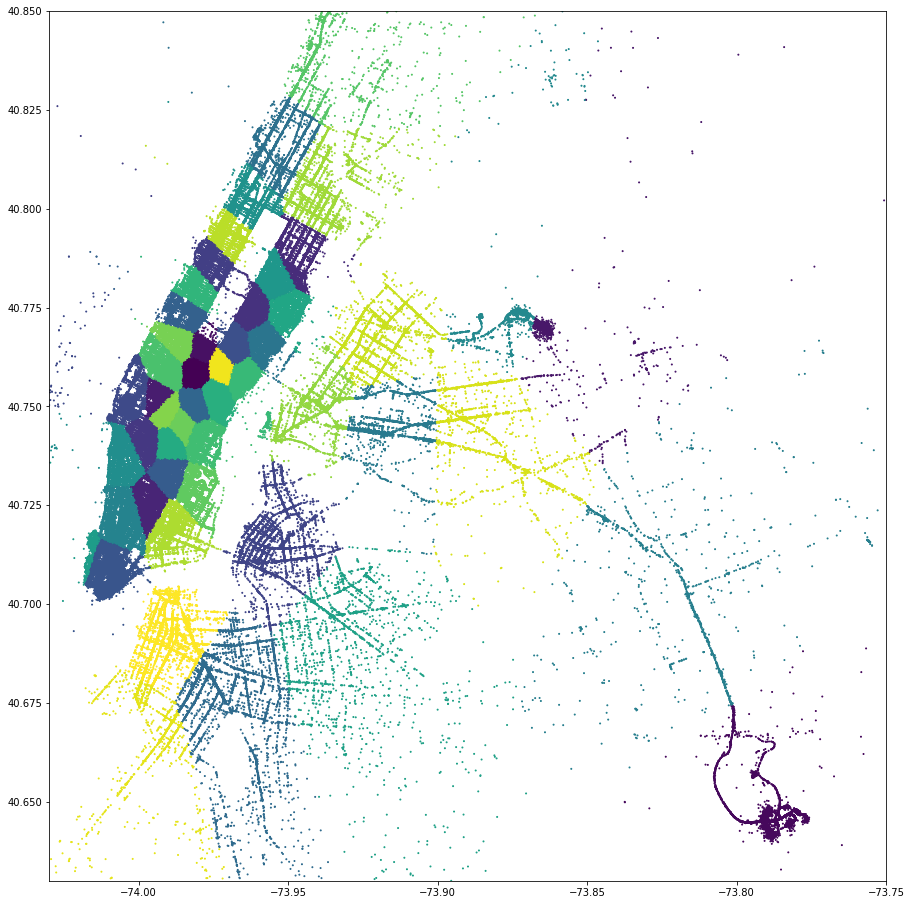

In [107]:
#display the cluster
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(15,16))    
ax.scatter( train.pickup_longitude.values,train.pickup_latitude.values, s =1, c = train.pickup_cluster)       
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.show()

Time analysis 


In [16]:
#pickup_datetime & dropoff_datetime
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['pickup_date'] = train['pickup_datetime'].dt.date
train['dropoff_date'] = train['dropoff_datetime'].dt.date

train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train['dropoff_weekday'] = train['dropoff_datetime'].dt.weekday
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['dropoff_hour'] = train['dropoff_datetime'].dt.hour

train['pickup_minute'] = train['pickup_datetime'].dt.minute
train['dropoff_minute'] = train['dropoff_datetime'].dt.minute
train['pickup_month'] = train['pickup_datetime'].dt.month
train['dropoff_month'] = train['dropoff_datetime'].dt.month

test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_weekday'] = test['pickup_datetime'].dt.weekday
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_minute'] = test['pickup_datetime'].dt.minute
test['pickup_month'] = test['pickup_datetime'].dt.month



train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map(lambda x : 1 if x == 'Y' else 0)
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].map(lambda x : 1 if x == 'Y' else 0)


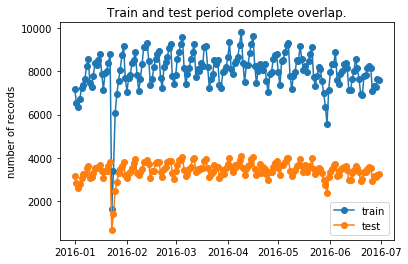

In [28]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

snow storm in north-eastern America during Jan 2016 may explain the number drop in 2016-01

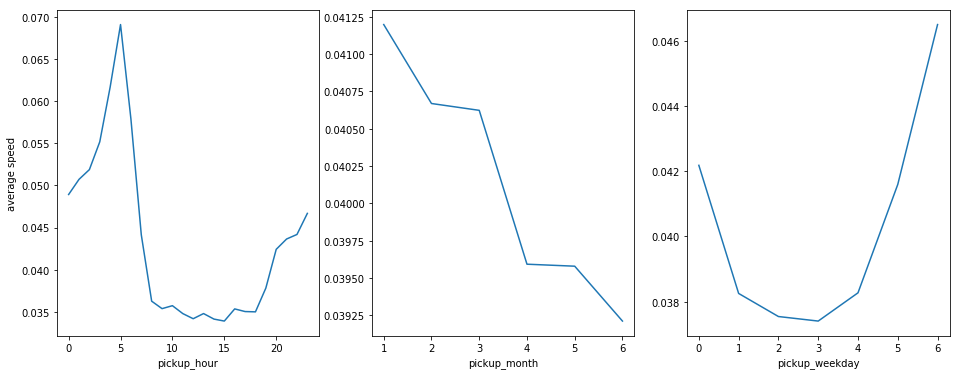

In [143]:
# speed for each trip
train['speed']  = train['distance'] / train['trip_duration']

fig , ax = plt.subplots(ncols = 3, figsize=(16,6))
ax[0].plot(train[['pickup_hour','speed']].groupby('pickup_hour').mean()[['speed']] )
ax[1].plot(train[['pickup_month','speed']].groupby('pickup_month').mean()[['speed']] )
ax[2].plot(train[['pickup_weekday','speed']].groupby('pickup_weekday').mean()[['speed']] )
ax[0].set_xlabel('pickup_hour')
ax[1].set_xlabel('pickup_month')
ax[2].set_xlabel('pickup_weekday')
ax[0].set_ylabel('average speed')
plt.show()

From above plot, it seem that pickup time have significant impact on the traffic in NYC
- pickup hour : 8-17 are the peak time and have the lowest speed
- pickup month : It seem to have seasonal affect on NYC traffic time
- pickup weekday : Speed seems to be lower during work day(Mon-Fri)


In [ ]:
#add columns worktime to determine if the pickuptime is during the working time(8-18 from Mon to Fri) 
train['work_time'] = np.where( (train['pickup_weekday']<6) & (train['pickup_hour']>8) & (train['pickup_hour'] <18), 1, 0)
test['work_time'] = np.where( (test['pickup_weekday']<6) & (test['pickup_hour']>8) & (test['pickup_hour'] <18), 1, 0)

(0, 100000)

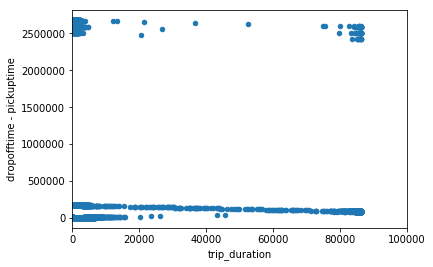

In [21]:
#eliminate the outlier data with trip_duration <= 0
train = train[train['trip_duration'] > 0] 

# duration ==> pickuptime - dropofftime
def timeDutation(pickup_time, dropoff_time):
    
    date_p = pickup_time.dt.day
    date_d = dropoff_time.dt.day
    hr_p = pickup_time.dt.hour
    hr_d = dropoff_time.dt.hour
    min_p = pickup_time.dt.minute
    min_d = dropoff_time.dt.minute
    sec_p = pickup_time.dt.second
    sec_d = dropoff_time.dt.second
    
    return np.abs(date_d - date_p)*24*60*60 + np.abs((hr_d - hr_p))*60*60 + np.abs((min_d - min_p))*60 + np.abs(sec_d - sec_p)    
    

train['duration'] = timeDutation(train['pickup_datetime'], train['dropoff_datetime'])
train.plot(kind='scatter', x='trip_duration', y='duration')
plt.xlabel('trip_duration')
plt.ylabel('dropofftime - pickuptime')
plt.xlim((0,100000))

1.there seems to have huge gap between trip duration and difference between pickuptime and dropofftime
2.testing data do not have information of dropofftime, so we do not take dropofftime into consideration

(0, 100000)

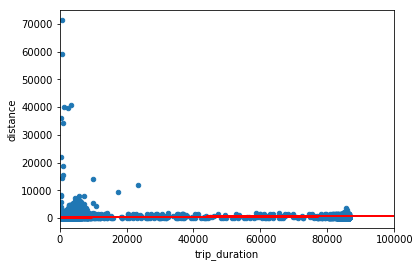

In [27]:
train.plot(kind='scatter', x='trip_duration', y='distance')
z = np.polyfit(train.trip_duration, train.distance, 1)
p = np.poly1d(z)
plt.plot(train.trip_duration,p(train.trip_duration),"r--")
plt.xlim((0,100000))

network analysis
1.Use the each cluster as the node in network
2.Each cluster represent each node, average traffic time between each cluster represent each weighted edge between 
  cluster
3.Use shortest path steps and shortest weight length to estimate the distance between pickup cluster and dropoff   
  cluster

In [127]:
import warnings
import networkx as nx
warnings.filterwarnings('ignore')

In [129]:
G = nx.Graph()  
for i in range(50):
    G.add_node(i)   

temp = train[['pickup_cluster','dropoff_cluster','trip_duration']]

for i in range(50):
    
        for j in range(50):
            if temp.loc[(temp['pickup_cluster'] == i) & (temp['dropoff_cluster'] == j)].shape[0] > 0:
                weight = temp.groupby(['pickup_cluster','dropoff_cluster']).get_group((i,j)).mean().trip_duration
                G.add_weighted_edges_from([(i,j,weight)])

network_pred = []
network_step = []
for i in range(train.shape[0]):
    network_pred.append(nx.dijkstra_path_length(G,source=train['pickup_cluster'].loc[i],target=train['dropoff_cluster'].loc[i]))
    network_step.append(nx.shortest_path_length(G,source=train['pickup_cluster'].loc[i] ,target=train['dropoff_cluster'].loc[i]))

train['network_pred'] = np.array(network_pred)  #shortest weighted length 
train['network_step'] = np.array(network_step)  #shortest path steps

network_pred_test = []
network_step_test = []
for i in range(test.shape[0]):
    network_pred_test.append(nx.dijkstra_path_length(G,source=test['pickup_cluster'].loc[i],target=test['dropoff_cluster'].loc[i]))
    network_step_test.append(nx.shortest_path_length(G,source=train['pickup_cluster'].loc[i] ,target=train['dropoff_cluster'].loc[i]))

test['network_pred'] = np.array(network_pred_test)   #shortest weighted length 
test['network_step'] = np.array(network_step_test)   #shortest path steps 


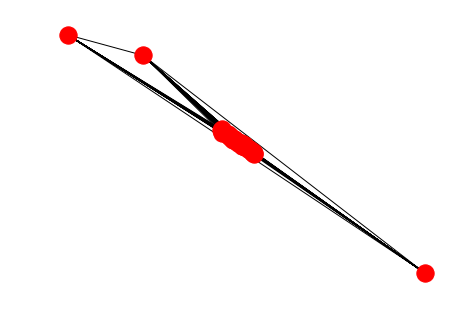

In [137]:
#show the network
nx.draw(G)             
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')
plt.show() 
plt.savefig("network.png")  

analyze average speed in each trip (pickup cluster -> dropoff cluster)

In [139]:
#estimete avg speed groupby each trip(pickup cluster -> dropoff cluster) as  bw_speed_tb

train_speed = train[['pickup_cluster','dropoff_cluster','speed']]
bw_speed_tb = []

for i in range(50):
    cols = []
    for j in range(50):
        
        if train[(train['pickup_cluster'] == i) & (train['dropoff_cluster'] ==j) ].shape[0] > 0:
            temp = train_speed.groupby(['pickup_cluster','dropoff_cluster']).get_group((i,j)).mean().speed
            cols.append(temp)
        else:
            cols.append(0)
    bw_speed_tb.append(cols)  
            

In [142]:
#avg_speed_h_pickup_cluster_dropoff_cluster
#estimate avg speed by each cluster
train_speed = train[['pickup_cluster','dropoff_cluster','speed']]

bw_speed = []
bw_speed_test = []
for row in range(train.shape[0]):
    i = train['pickup_cluster'].loc[row]
    j = train['dropoff_cluster'].loc[row]
    bw_speed.append(bw_speed_tb[i][j])

bw_speed = np.array(bw_speed)
    
for row_t in range(test.shape[0]):
    i = test['pickup_cluster'].loc[row_t]
    j = test['dropoff_cluster'].loc[row_t]
    bw_speed_test.append(bw_speed_tb[i][j])
    
bw_speed_test = np.array(bw_speed_test)    
    

train['speed_bt_cluster'] = bw_speed  
test['speed_bt_cluster'] = bw_speed_test



In [144]:
train.to_csv('train_network.csv')
test.to_csv('test_network.csv')

From above, it seem to have seasonal effect on NYC's traffic. 
we combine the NYC weather record 2016 including temperature, snow and so on.


In [12]:
dftrain = train
dftest = test

weather = pd.read_csv('weather_data_nyc_centralpark_2016.csv')
weather['day'] = weather['date'].apply(lambda x : x.split('-')[0])
weather['mon'] = weather['date'].apply(lambda x : x.split('-')[1])
weather['year'] = weather['date'].apply(lambda x : x.split('-')[2])
weather['date'] = pd.to_datetime(weather['date'])
df_date = pd.DataFrame({'year': weather['year'].values,'month': weather['mon'].values,'day': weather['day'].values})
weather['date2016'] = pd.to_datetime(df_date).dt.date

dftrain = pd.merge(train, weather,how='left', left_on='pickup_date', right_on='date2016')
dftest = pd.merge(test, weather,how='left', left_on='pickup_date', right_on='date2016')
dftrain['snow depth'].replace('T',0.01,inplace = True)
dftest['snow depth'].replace('T',0.01,inplace = True)
dftrain['precipitation'].replace('T',0.01,inplace = True)
dftest['precipitation'].replace('T',0.01,inplace = True)
dftrain['snow fall'].replace('T',0.01,inplace = True)
dftest['snow fall'].replace('T',0.01,inplace = True)

dftrain.drop(['year','mon','day'],axis = 1,inplace = True)
dftest.drop(['year','mon','day'],axis = 1,inplace = True)

Combine OSRM Features
Now we use better fastest route distance data (https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm) between pickup and dropoff to help us estimate.


In [15]:
routes1 = pd.read_csv('fastest_routes_train_part_1.csv')
routes2 = pd.read_csv('fastest_routes_train_part_2.csv')
routes = routes1.append(routes2, ignore_index = True)
routes = routes[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
dftrain = pd.merge(dftrain, routes, how = 'left', on = 'id')

routes = pd.read_csv('fastest_routes_test.csv')
routes = routes[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
dftest = pd.merge(dftest, routes, how = 'left', on = 'id')

dftrain.fillna(0, inplace = True)
dftest.fillna(0, inplace = True)

In [28]:
dftrain.loc[:, 'pickup_dt'] = (dftrain['pickup_datetime'] - dftrain['pickup_datetime'].min()).dt.total_seconds() 
dftest.loc[:, 'pickup_dt'] = (dftest['pickup_datetime'] - dftest['pickup_datetime'].min()).dt.total_seconds()

group_cols = [['pickup_hour','pickup_cluster'],['pickup_hour', 'dropoff_cluster']]

for gby_cols in group_cols:
    coord_speed = dftrain.groupby(gby_cols).mean()[['np_trip_duration']].reset_index()
    coord_speed.columns = gby_cols + ['duration_group']
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_count.columns = gby_cols + ['duration_group']
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    dftrain = pd.merge(dftrain, coord_speed, how='left', on=gby_cols)
    dftest = pd.merge(dftest, coord_speed, how='left', on=gby_cols)

for gby_col in ['pickup_hour', 'pickup_dt','pickup_cluster', 'dropoff_cluster']:
    gby = dftrain.groupby(gby_col).mean()[['speed', 'np_trip_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    dftrain = pd.merge(dftrain, gby, how='left', left_on=gby_col, right_index=True)
    dftest = pd.merge(dftest, gby, how='left', left_on=gby_col, right_index=True)

In [35]:
print(dftrain.shape)
print(dftest.shape)


(1439224, 71)
(625134, 60)


In [36]:
dftrain.columns

Index(['index', 'id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'np_trip_duration', 'distance', 'distance_haversine',
       'direction', 'pickup_cluster', 'dropoff_cluster', 'pickup_date',
       'dropoff_date', 'pickup_weekday', 'dropoff_weekday', 'pickup_hour',
       'dropoff_hour', 'pickup_minute', 'dropoff_minute', 'pickup_month',
       'dropoff_month', 'duration', 'speed', 'pickup_pca0', 'pickup_pca1',
       'dropoff_pca0', 'dropoff_pca1', 'dist_x', 'dist_y', 'work_time',
       'center_latitude', 'center_longitude', 'network_pred', 'network_step',
       'speed_bt_cluster', 'date', 'maximum temerature', 'minimum temperature',
       'average temperature', 'precipitation', 'snow fall', 'snow depth',
       'date2016', 'total_distance', 'total_travel_time', 'number_of_steps',
       'pickup_dt', 'pickup_lat_bin'

In [38]:
dftest.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'distance',
       'distance_haversine', 'direction', 'pickup_cluster', 'dropoff_cluster',
       'pickup_date', 'pickup_weekday', 'pickup_hour', 'pickup_minute',
       'pickup_month', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0',
       'dropoff_pca1', 'dist_x', 'dist_y', 'work_time', 'center_latitude',
       'center_longitude', 'network_pred', 'network_step', 'speed_bt_cluster',
       'date', 'maximum temerature', 'minimum temperature',
       'average temperature', 'precipitation', 'snow fall', 'snow depth',
       'date2016', 'total_distance', 'total_travel_time', 'number_of_steps',
       'pickup_dt', 'pickup_lat_bin', 'pickup_long_bin', 'center_lat_bin',
       'center_long_bin', 'pickup_dt_bin', 'duration_gb_hr',
       'duration_gb_cluster', 'duration_gb_center', 'duration_gb_hr_center',
       'sp

In [ ]:
#train
y_train = dftrain['np_trip_duration']
drop_cols = ['index','trip_duration',  'np_trip_duration', 'id','pickup_datetime','dropoff_datetime', 'duration','speed', 'pickup_date',\
               'dropoff_date','dropoff_weekday','dropoff_hour','dropoff_minute','dropoff_month','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','date','date2016']        
x_train = dftrain.drop(drop_cols, axis = 1)
x_train.shape

In [42]:
#test
drop_test_cols = ['id','pickup_datetime','pickup_date','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','date','date2016']
x_test = dftest.drop(drop_test_cols, axis = 1)
x_test.shape

(625134, 51)

Model


In [46]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier,XGBRegressor

from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [48]:
#get_dummies for categorical feature
col_getdummies = ['vendor_id','pickup_month','pickup_weekday','pickup_hour']

for col in col_getdummies:
    x_train = pd.concat((x_train, pd.get_dummies(x_train[col], prefix= col)), axis = 1)
    del x_train[col]
        
for col in col_getdummies:
    x_test = pd.concat((x_test, pd.get_dummies(x_test[col], prefix= col)), axis = 1)
    del x_test[col]


In [53]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train.values, y_train, test_size=0.2, random_state=8)

In [58]:
xgbr =  XGBRegressor( learning_rate =0.3, n_estimators=400, 
                        gamma=0.2,alpha = 0.05, subsample=0.8, colsample_bytree=0.8,seed=27,max_depth = 10 ,min_child_weight = 14)
                       
model = xgbr.fit(x_tr,y_tr)                       
y_pred = model.predict(x_tr)   
y_pred_val= model.predict(x_val) 
y_pred_lg = np.exp(y_pred)
y_pred_val_lg = np.exp(y_pred_val)

In [60]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_tr, y_pred_lg)**0.5) #RMSE_train
print(mean_squared_error(y_val, y_pred_val_lg)**0.5)  #RMSE_val

5267.78777947
3269.37410121


In [65]:
y_pred = model.predict(x_test.values)
test['trip_duration_pred'] = np.exp(y_pred)
test[['id', 'trip_duration_pred']].to_csv('submission.csv', index=False)

In [69]:
imp = model.feature_importances_
imp = pd.DataFrame({'feature': x_train.columns, 'score': imp})
imp = imp.sort_values(['score'], ascending=[0])
imp

,feature,score
42,np_trip_duration_gby_pickup_dt_bin,0.178088
41,speed_gby_pickup_dt_bin,0.158154
2,distance,0.080675
26,total_distance,0.050248
3,distance_haversine,0.049646
27,total_travel_time,0.043930
4,direction,0.032496
19,speed_bt_cluster,0.032157
17,network_pred,0.027381
12,dist_x,0.026403
